In [43]:
import numpy as np
import matplotlib.pyplot as plt
import nbimporter
import import_ipynb
%run random_shannon_fcns.ipynb

torch.set_default_dtype(torch.float32)

## Time Series Forecasting

### Forecasting Algorithms

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

class TimeSeriesMLP(nn.Module): 
    """ 
        Basic MLP used as a regression model for delay-embedded coordinates
    """
    def __init__(self, out_dim, latent_dim): 
        super(TimeSeriesMLP, self).__init__()

        layer1 = MLP(out_dim, latent_dim, out_dim, nonlinearity='relu')

        self.fnn = layer1

    def forward(self, x): 
        x = self.fnn(x)
        return x

class DelayEmbeddingMLP(nn.Module):
    """
    An MLP model to learn the dynamics of state vectors.
    It takes a state vector and predicts the next state vector.
    """
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Args:
            input_dim (int): The size of the input state vector (embedding_dim).
            hidden_dim (int): The number of neurons in the hidden layers.
            output_dim (int): The dimension of the output vector (embedding_dim).
        """
        super(DelayEmbeddingMLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        # The input x is a batch of state vectors.
        return self.network(x)

class KoopmanNet(nn.Module):
    """
        Autoencoder-style Koopman operator model.
          encoder: x -> z = phi(x)
          K:       z_next_pred = K z
          decoder: z -> x_hat = psi(z)
        Trains with reconstruction + Koopman consistency in latent space.
    """
    def __init__(
        self,
        input_dim: int,
        latent_dim: int,
        enc_hidden=(128, 128),
        dec_hidden=(128, 128),
        activation="relu",
        norm=None,
        dropout=0.0,
        init="xavier",
        bias=True,
        init_scale=0.05,   # range for uniform init of K in [-init_scale, init_scale]
    ):
        super().__init__()

        self.encoder = MLP(
            num_input=input_dim,
            num_hidden=list(enc_hidden),
            num_output=latent_dim,
            nonlinearity=activation,
            norm=norm,
            dropout=dropout,
            out_nonlinearity=None,
            init=init,
            bias=bias,
        )
        self.decoder = MLP(
            num_input=latent_dim,
            num_hidden=list(dec_hidden),
            num_output=input_dim,
            nonlinearity=activation,
            norm=norm,
            dropout=dropout,
            out_nonlinearity=None,
            init=init,
            bias=bias,
        )

        # Koopman operator (shared linear map in latent space)
        self.K = nn.Parameter(torch.empty(latent_dim, latent_dim))
        nn.init.uniform_(self.K, -init_scale, init_scale)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def evolve_latent(self, z, steps=1):
        """
            z_{t+k} = (K^T)^k z_t (since we use row-vectors times weight^T in Linear)
            Here we explicitly multiply by K^T so it's consistent with z @ K.T.
        """
        Kt = self.K.T
        out = z
        for _ in range(steps):
            out = out @ Kt
        return out

    @torch.no_grad()
    def eig(self):
        """
            Returns eigenvalues/vectors of K.
            K V = V diag(λ); columns of V are eigenvectors.
        """
        K_cpu = self.K.detach().cpu()
        vals, vecs = torch.linalg.eig(K_cpu)
        return vals, vecs

    def forward(self, x, x_next=None, steps = 1):
        """
            If x_next is given, also returns z_next_true for loss computation.
            Returns: dict with z, z_next_pred, x_hat, and (optional) z_next_true
        """
        z = self.encode(x)
        z_next_pred = self.evolve_latent(z, steps=steps)
        x_hat = self.decode(z)

        out = {"z": z, "z_next_pred": z_next_pred, "x_hat": x_hat}
        if x_next is not None:
            out["z_next_true"] = self.encode(x_next)
        return out

    def loss_components(
        self,
        x,
        x_next,
        steps = 1,
        alpha_recon = 1.0,
        alpha_koop = 1.0,
        alpha_diag = 0.0,   # off-diagonal L1 penalty (optional)
        reduction: str = "mean",
    ):
        """
            recon: ||x_hat - x||^2
            koop:  ||phi(x_{t+1}) - K^steps phi(x_t)||^2
            diag:  L1 penalty on off-diagonals of K (encourages eigenbasis)
        """
        out = self.forward(x, x_next=x_next, steps=steps)

        recon = F.mse_loss(out["x_hat"], x, reduction=reduction)
        koop  = F.mse_loss(out["z_next_pred"], out["z_next_true"], reduction=reduction)

        if alpha_diag != 0.0:
            K = self.K
            offdiag = K - torch.diag(torch.diag(K))
            diag_pen = offdiag.abs().mean() if reduction == "mean" else offdiag.abs().sum()
        else:
            diag_pen = torch.tensor(0.0, device=x.device)

        total = alpha_recon * recon + alpha_koop * koop + alpha_diag * diag_pen
        return {"total": total, "recon": recon, "koop": koop, "diag_pen": diag_pen, **out}


### Helpers

In [3]:
def generate_timeseries(key, length): 
    if key == 'logistic':
        print("Using Logistic Map dataset.")
        series = logistic_map(r=3.99, x_0=0.5, max_iter=length)
    elif key == 'weierstrass':
        print("Using Weierstrass Function dataset.")
        x_vals = np.linspace(-2, 2, length)
        series = weierstrass(x=x_vals, a=0.5, b=3, max_n=15)
    elif key == 'doublesine': 
        print("Using double sinusoid dataset.")
        x_vals = np.linspace(-1000, 1000, length)
        series = double_sinusoid(x_vals)
    elif key == 'chirp': 
        print("Using chirp dataset.")
        x_vals = np.linspace(-1000, 1000, length)
        series = chirp(x_vals)
    elif key == 'macglass': 
        print("Using discrete Mackey-Glass dataset.")
        series = mackey_glass_discrete(N=length, tau=17, beta=0.2, gamma=0.1, n=10, x0=1.2)
    else:
        raise ValueError("Unknown dataset specified.")
        
    return series 
    
def create_io_pairs(arr):
    """
    Creates input-output pairs (x_t, x_{t+1}) for 1D or 2D arrays.
    1D -> returns (T-1, 1); 2D -> returns (T-1, d).
    """
    arr = np.asarray(arr)
    x = arr[:-1]
    y = arr[1:]
    if arr.ndim == 1:
        x = x[:, None]
        y = y[:, None]
    elif arr.ndim != 2:
        raise ValueError(f"Expected 1D or 2D, got {arr.ndim}D with shape {arr.shape}")
    return x, y

def create_forecast_set(time_series, lb, step=1): 
    x, y = [], []
    for i in range(0, len(time_series)-lb): 
        feat = time_series[i:i+lb]
        tar = time_series[i+step:i+lb+step]
        x.append(feat)
        y.append(tar)

    return torch.from_numpy(np.array(x)), torch.from_numpy(np.array(y))

def split_timeseries(timeseries, train_frac): 
    """
        Split data into train, valid, and test
    """
    N = int(len(timeseries))

    n_train = int(N * train_frac)

    return timeseries[:n_train], timeseries[n_train:]

def split_timeseries_io(inputs, outputs, train_frac=0.8):
    """
        Splits data into training and testing sets.
    """
    n_train = int(len(inputs) * train_frac)
    x_train, x_test = inputs[:n_train], inputs[n_train:]
    y_train, y_test = outputs[:n_train], outputs[n_train:]
    return x_train.astype(np.float32), y_train.astype(np.float32), x_test.astype(np.float32), y_test.astype(np.float32)

def create_takens_io(timeseries, dim, delay, train_frac): 
    takens = delay_embed(timeseries, dim, delay)
    inp, outp = create_io_pairs(takens)
    x_train, y_train, x_test, y_test = split_timeseries_io(inp, outp, train_frac)

    return x_train.astype(np.float32), y_train.astype(np.float32), x_test.astype(np.float32), y_test.astype(np.float32)

In [4]:
def Train(model, dataloader, optimizer, criterion=nn.MSELoss(), device='cpu', epochs=100):
    """
        A simple training loop for the MLP model.
    """
    model.train()
    loss_history = []
    print("Starting training...")
    for epoch in range(epochs):
        total_loss = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            preds = model(x_batch)
            loss = criterion(y_batch, preds)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")
    print("Training finished.")
    
    return loss_history

def Test(model, dataloader, device='cpu'): 
    model.eval()

    preds, true = [], []
    with torch.no_grad():
        for input, target in dataloader: 
            input = input.to(device)
            target = target.to(device)
            output = model(input)

            preds.extend(output[:, -1].numpy())
            true.extend(target[:, -1].numpy())

    return preds, true

def return_de_preds(model, x, y): 
    """
        Reverse transformation for delay-embedded curve prediction. Takes the last element in each block. 
    """
    model.eval()
    with torch.no_grad(): 
        preds = model(x)

    out = []
    for i in range(len(preds)): 
        out = np.hstack((out, preds[i][-1][-1]))

    return np.array(out)

def train_koop(model, dataloader, optimizer, device='cpu', epochs=100):
    """
        A simple training loop for the KoopmanNet model.
    """
    model.train()
    loss_history = []
    print("Starting training...")
    for epoch in range(epochs):
        total_loss = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            losses = model.loss_components(x_batch, y_batch)
            loss = losses["total"]
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")
    print("Training finished.")
    return loss_history

def test_koop(model, X_test, y_test, device='cpu'):
    """
        Evaluates the model and returns one-step predictions and losses.
    """
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.from_numpy(X_test).to(device)
        y_test_tensor = torch.from_numpy(y_test).to(device)
        
        losses = model.loss_components(X_test_tensor, y_test_tensor)
        
        # Get one-step predictions
        forward_out = model.forward(X_test_tensor)
        z_next_pred = forward_out['z_next_pred']
        x_next_pred = model.decode(z_next_pred).numpy()

    print("\n--- Test Results ---")
    print(f"Total Loss:  {losses['total'].item():.6f}")
    print(f"Recon Loss:  {losses['recon'].item():.6f}")
    print(f"Koopman Loss: {losses['koop'].item():.6f}")
    
    return x_next_pred

# --- Visualization ---

def plot_results(X_test, y_test, y_pred, loss_history):
    """
        Plots training loss and test predictions.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot training loss
    ax1.plot(loss_history)
    ax1.set_title("Training Loss Over Epochs")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Total Loss")

    # Plot test predictions vs. ground truth
    ax2.plot(y_test, label="Ground Truth", marker='.', linestyle='None', color='blue', alpha=0.6)
    ax2.plot(y_pred, label="One-Step Prediction", marker='x', linestyle='None', color='red', alpha=0.6)
    ax2.set_title("Test Set: Predictions vs. Ground Truth")
    ax2.set_xlabel("Time Step")
    ax2.set_ylabel("Value")
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

def plot_preds(y, y_pred): 
    plt.figure(figsize=(20,10))
    plt.title("Test Data")
    plt.plot(y_pred, '-b.', label="prediction")
    plt.plot(y, '-r.', label="ground truth")
    plt.legend()
    
    plt.show()

def plot_error(y, y_pred, f): 
    """
        plot prediction error computed by f(y, y_pred)
    """
    pred_error = f(y, y_pred)

    plt.figure(figsize=(12, 6))
    plt.plot(test_error)
    plt.title("Prediction Error on the Test Set")
    plt.xlabel("Time Step")
    plt.ylabel("Error (True - Predicted)")
    plt.grid(True)
    plt.show()

### Koopman Operator vs. Delay Embedding

Oftentimes an observed equidistant 1-dimensional time series $\{x_t\}_{t=1, 2, \dots, N}$ is believed to be a *measurement* of some $d$-dimensional dynamical system described by 
$$x_k = h(s_k) = h(f^k(s_0))$$
where $f^k$ denotes the $k$-fold iteration of a smooth dynamical system $f: M \to M$ and $h: M \to \mathbb{R}$ the *measurement function*. By *state space reconstruction* we mean the problem of recreating the states $s_i$ only given the measurements $x_i$. Even though it is typically impossible to reconstruct the states in its original coordinates as both $f$ and $h$ are unknown, we may be able to estimate $\hat{s}_i$ that is mathematically equivalent (diffeomorphic) to the original form $s_i$. The notebook below implements and benchmarks a few different data-driven approaches to state space reconstruction. 

In [5]:
from torch.utils.data import Dataset, DataLoader
DATASET = generate_timeseries('doublesine', 1000) 

Using double sinusoid dataset.


#### Koopman Operator

In [6]:
inputs_koop, outputs_koop = create_io_pairs(DATASET)
x_train_koop, y_train_koop, x_test_koop, y_test_koop = split_timeseries_io(inputs_koop, outputs_koop)

BATCH_SIZE = 32
train_dataset_koop = TensorDataset(torch.from_numpy(x_train_koop), torch.from_numpy(y_train_koop))
train_loader_koop = DataLoader(train_dataset_koop, batch_size=BATCH_SIZE, shuffle=True)

print(x_train_koop.dtype)

float32


Starting training...
Epoch [10/500], Loss: 0.001027
Epoch [20/500], Loss: 0.000412
Epoch [30/500], Loss: 0.000736
Epoch [40/500], Loss: 0.000788
Epoch [50/500], Loss: 0.000658
Epoch [60/500], Loss: 0.000394
Epoch [70/500], Loss: 0.000275
Epoch [80/500], Loss: 0.001456
Epoch [90/500], Loss: 0.000173
Epoch [100/500], Loss: 0.000374
Epoch [110/500], Loss: 0.001810
Epoch [120/500], Loss: 0.000142
Epoch [130/500], Loss: 0.000194
Epoch [140/500], Loss: 0.000106
Epoch [150/500], Loss: 0.000681
Epoch [160/500], Loss: 0.000134
Epoch [170/500], Loss: 0.000483
Epoch [180/500], Loss: 0.000089
Epoch [190/500], Loss: 0.000144
Epoch [200/500], Loss: 0.000102
Epoch [210/500], Loss: 0.000079
Epoch [220/500], Loss: 0.000102
Epoch [230/500], Loss: 0.000316
Epoch [240/500], Loss: 0.000070
Epoch [250/500], Loss: 0.000131
Epoch [260/500], Loss: 0.000066
Epoch [270/500], Loss: 0.000111
Epoch [280/500], Loss: 0.000068
Epoch [290/500], Loss: 0.000143
Epoch [300/500], Loss: 0.000268
Epoch [310/500], Loss: 0.000

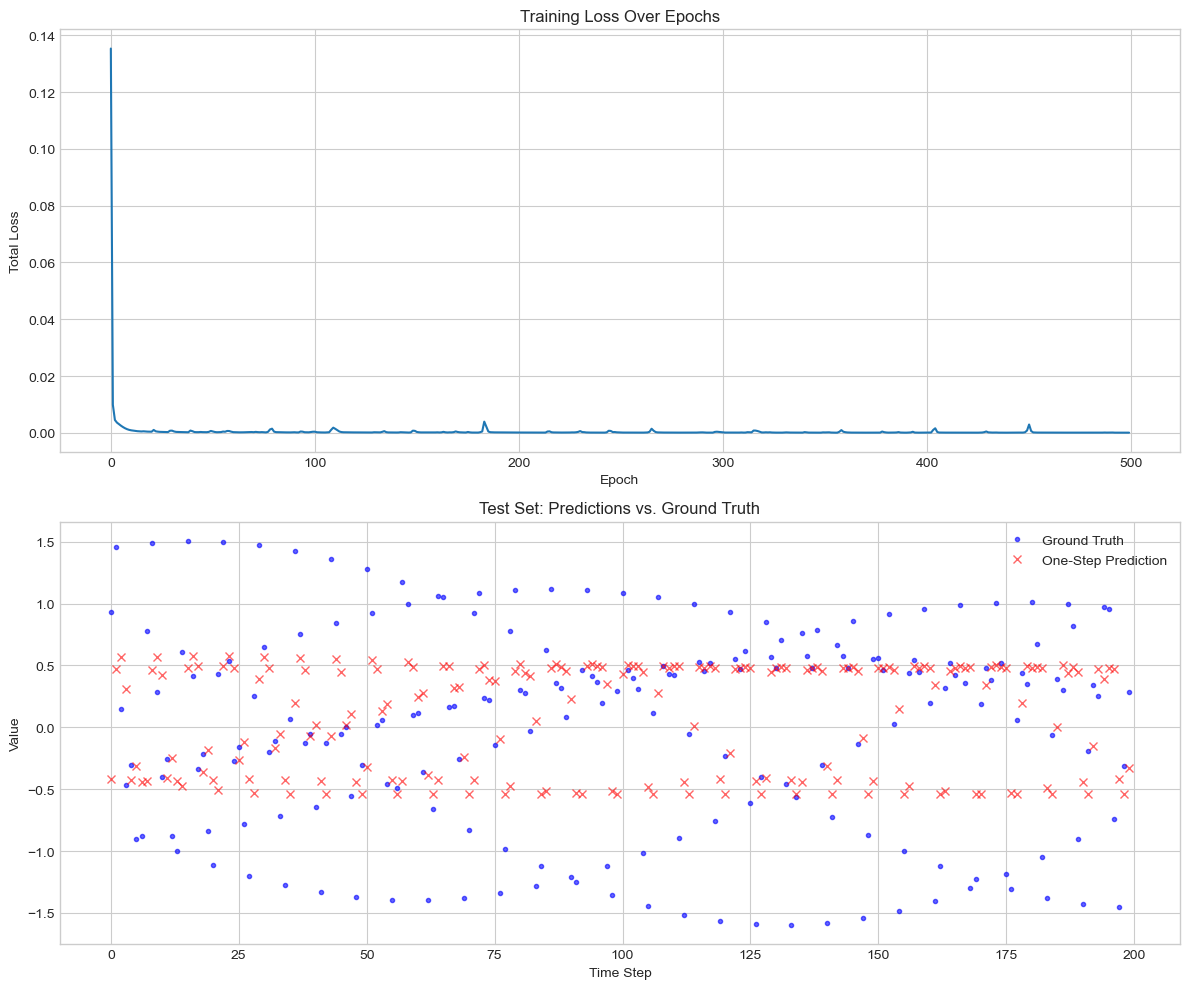

In [8]:
LATENT_DIM = 128
EPOCHS = 500
LEARNING_RATE = 1e-3

input_dim_koop = x_train_koop.shape[1]
model_koop = KoopmanNet(input_dim=input_dim_koop, latent_dim=LATENT_DIM)
optimizer = torch.optim.Adam(model_koop.parameters(), lr=LEARNING_RATE)

loss_history_koop = train_koop(model_koop, train_loader_koop, optimizer, epochs=EPOCHS)

y_pred_koop = test_koop(model_koop, x_test_koop, y_test_koop)

plot_results(x_test_koop, y_test_koop, y_pred_koop, loss_history_koop)

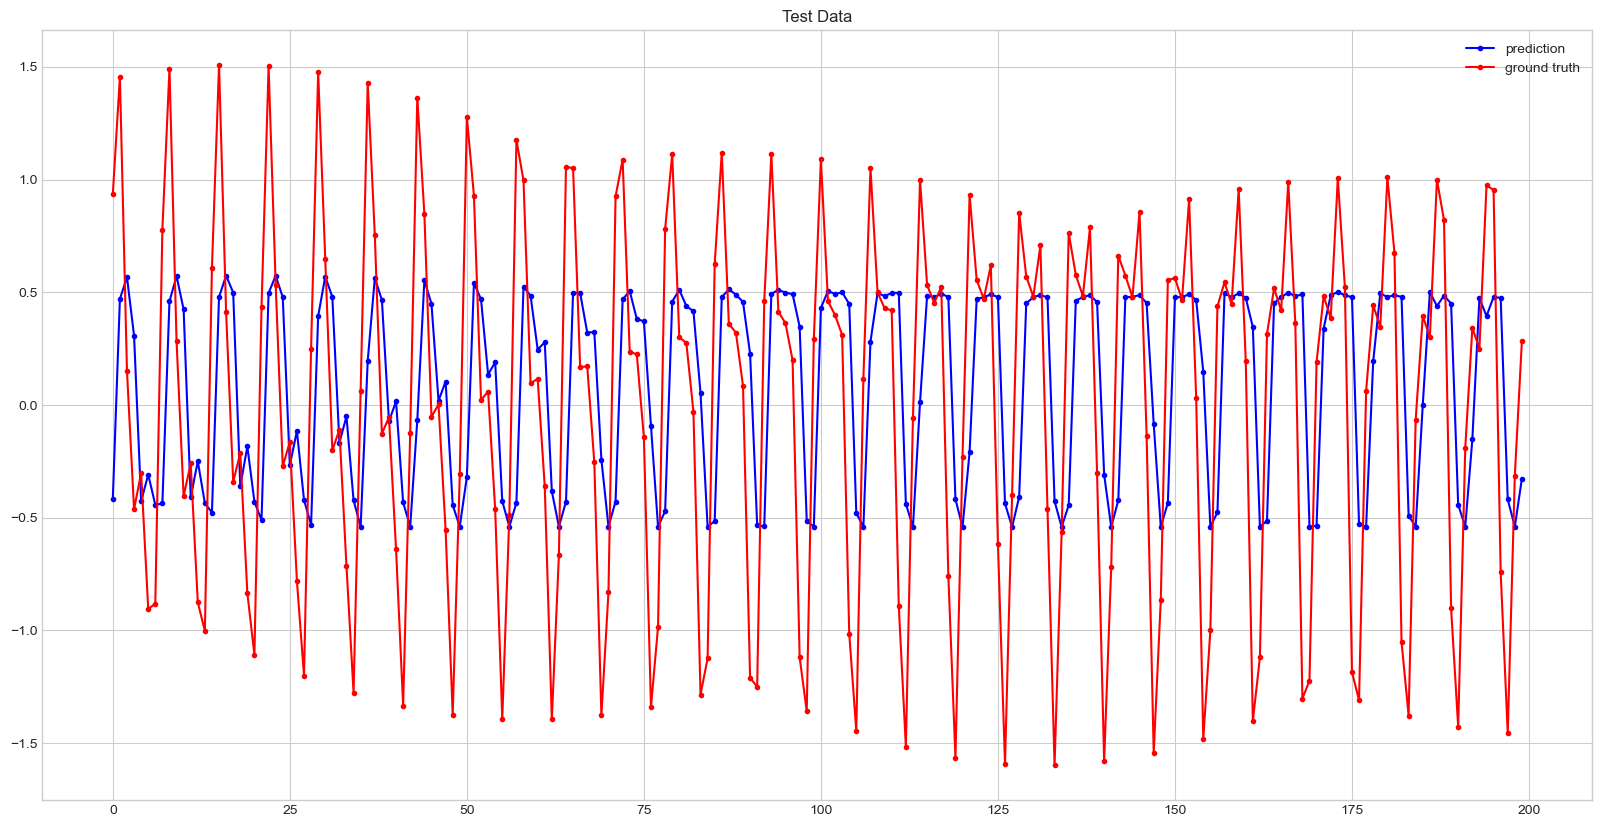

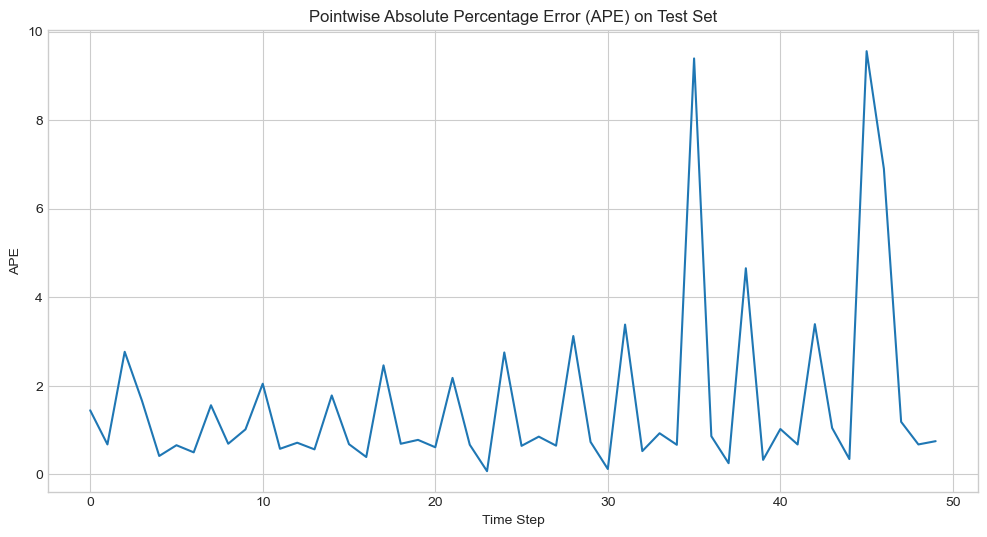

In [9]:
error_analyzer_koop = PredError(y_test_koop[0:50], y_pred_koop[0:50])
plot_preds(y_test_koop, y_pred_koop)
error_analyzer_koop.plot(error_type='ape')

#### Delay Embedding

somethings not working fix!!!

In [10]:
# LATENT_DIM = 16
# EPOCHS_de = 1000
# LEARNING_RATE_de = 1e-3
BATCH_SIZE_de = 32

delay = 1
emb_dim = 2

data = delay_embed(DATASET, emb_dim, delay)

train_de, test_de = split_timeseries(data, 0.7)

x_train_de, y_train_de, x_test_de, y_test_de = create_takens_io(DATASET, emb_dim, delay, 0.7)

train_dataset_de = TensorDataset(torch.from_numpy(x_train_de), torch.from_numpy(y_train_de))
train_loader_de = DataLoader(train_dataset_de, batch_size=16, shuffle=True)

test_dataset_de = TensorDataset(torch.from_numpy(x_test_de), torch.from_numpy(y_test_de))
test_loader_de = DataLoader(test_dataset_de, batch_size=16, shuffle=False)

In [11]:
model_de = TimeSeriesMLP(emb_dim, [128]*2)

optimizer_de = torch.optim.Adam(model_de.parameters(), lr=1e-3)

loss_history_de = Train(model_de, train_loader_de, optimizer_de, epochs=EPOCHS)

Starting training...
Epoch [10/500], Loss: 0.131362
Epoch [20/500], Loss: 0.128893
Epoch [30/500], Loss: 0.127874
Epoch [40/500], Loss: 0.124978
Epoch [50/500], Loss: 0.123961
Epoch [60/500], Loss: 0.125689
Epoch [70/500], Loss: 0.121807
Epoch [80/500], Loss: 0.124225
Epoch [90/500], Loss: 0.120358
Epoch [100/500], Loss: 0.119555
Epoch [110/500], Loss: 0.120306
Epoch [120/500], Loss: 0.118402
Epoch [130/500], Loss: 0.119149
Epoch [140/500], Loss: 0.118465
Epoch [150/500], Loss: 0.116594
Epoch [160/500], Loss: 0.115464
Epoch [170/500], Loss: 0.113444
Epoch [180/500], Loss: 0.113309
Epoch [190/500], Loss: 0.112560
Epoch [200/500], Loss: 0.112052
Epoch [210/500], Loss: 0.110128
Epoch [220/500], Loss: 0.110762
Epoch [230/500], Loss: 0.109197
Epoch [240/500], Loss: 0.107608
Epoch [250/500], Loss: 0.105498
Epoch [260/500], Loss: 0.106051
Epoch [270/500], Loss: 0.105733
Epoch [280/500], Loss: 0.104910
Epoch [290/500], Loss: 0.101580
Epoch [300/500], Loss: 0.101131
Epoch [310/500], Loss: 0.101

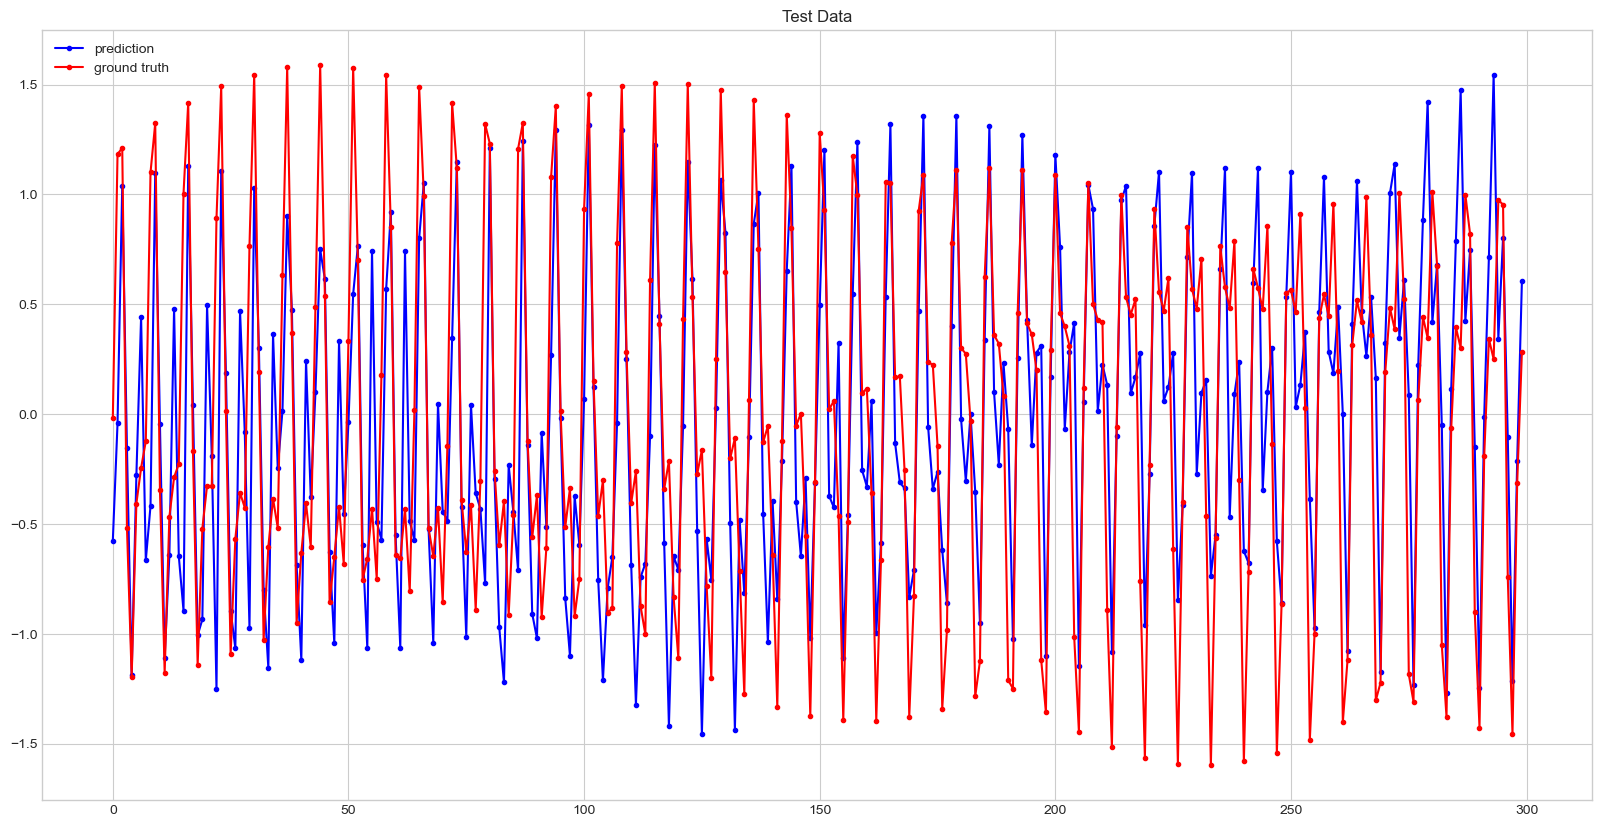

In [12]:
model_de.eval()

preds_de, true_de = Test(model_de, test_loader_de)

plot_preds(true_de, preds_de)

#### Plot errors below using the PredError class.

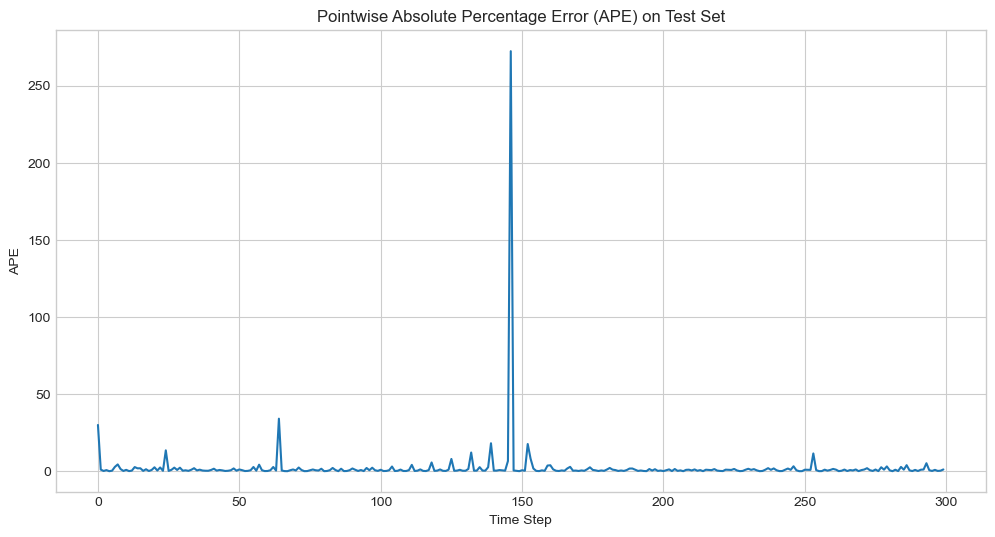

In [13]:
anal_error_de = PredError(true_de, preds_de)
anal_error_de.plot('ape')

#### Fix a parametrized time series. Measure forecast error and approximate entropy under varying parameters. draw graphs and make tables. 

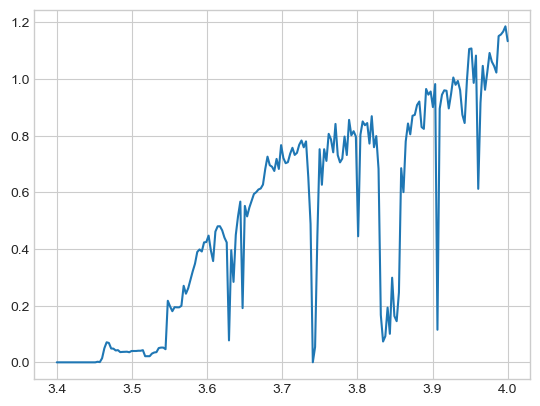

In [42]:
range_r = (3.4, 4.0)
num_r = 200
r_values = np.linspace(range_r[0], range_r[1], num_r)

entropy_list = []
for val in r_values: 
    data = logistic_map(val, 0.2, 200)
    radius = 0.1 * np.std(data)
    entropy_list.append(approx_entropy(data, 1, 2, radius))

plt.plot(r_values, entropy_list)

#### Futher benchmark performances of the models above to something more classical. Like kernels, fourier, discrete derivatives, and polynomial basis expansions. 